In [41]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

### Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [42]:
train_df = pd.read_csv('/home/mathewlech/sandbox_local/input/titanic/train.csv')
test_df = pd.read_csv('/home/mathewlech/sandbox_local/input/titanic/test.csv')
combine = [train_df, test_df]
transformed_Sex = False
transformed_Embark = False

age_buckets = 20
fare_buckets = 10

#train_df.info()
print("--"*40)
#test_df.info()

--------------------------------------------------------------------------------


In [43]:
# Outlier detection 
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [44]:
train_df.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [45]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

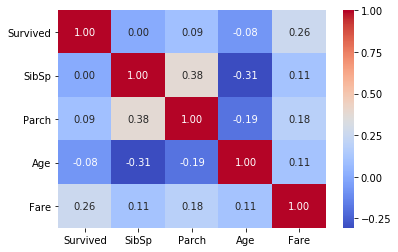

In [46]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train_df[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

* 77% of cabin is null probably not much use for this column
* passengerID doesn't intrinsically give us any real information
* Ticket doesnt seemt to provide insight


### Data manipulations

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * 

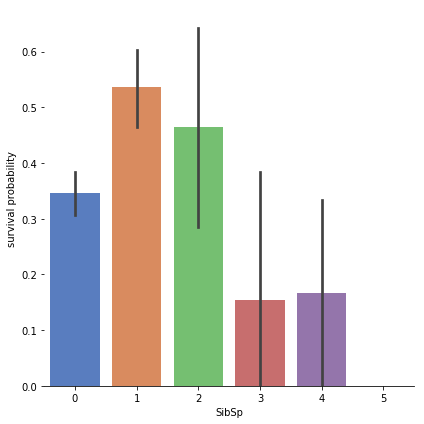

In [47]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train_df,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * 

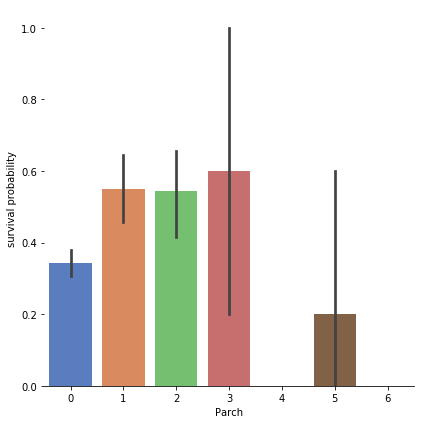

In [48]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train_df,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


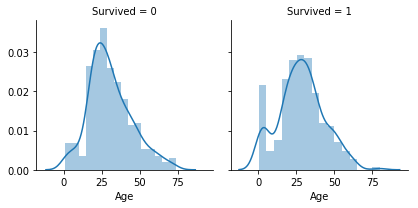

In [49]:
# Explore Age vs Survived
g = sns.FacetGrid(train_df, col='Survived')
g = g.map(sns.distplot, "Age")

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


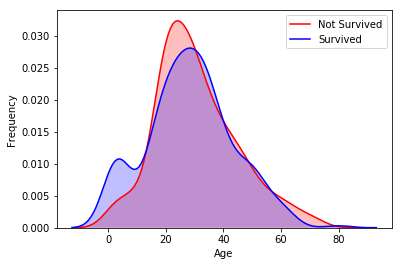

In [50]:
# Explore Age distibution 
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 0) & (train_df["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 1) & (train_df["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


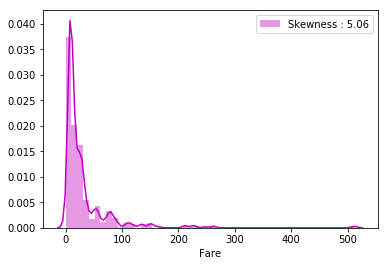

In [51]:
# Explore Fare distribution 
g = sns.distplot(train_df["Fare"], color="m", label="Skewness : %.2f"%(train_df["Fare"].skew()))
g = g.legend(loc="best")

In [52]:
# Apply log to Fare to reduce skewness distribution
train_df["Fare"] = train_df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * 

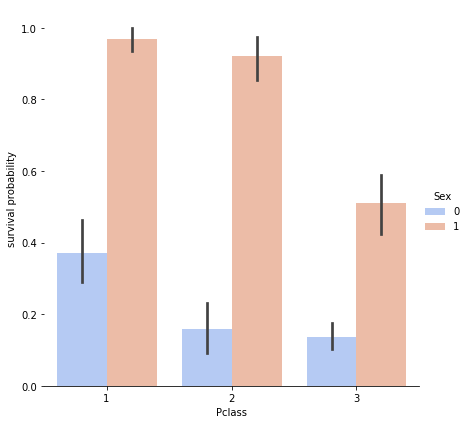

In [87]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train_df,
                   size=6, kind="bar", palette="coolwarm")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * 

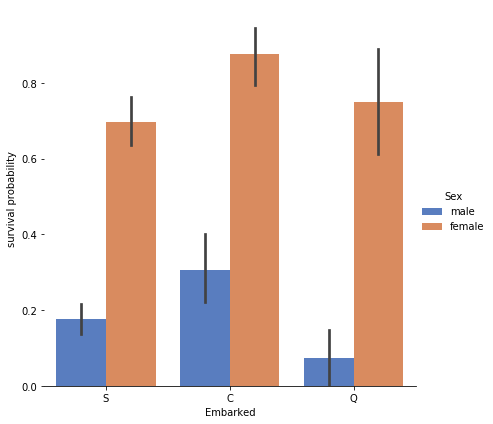

In [54]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",hue="Sex",   data=train_df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the defau

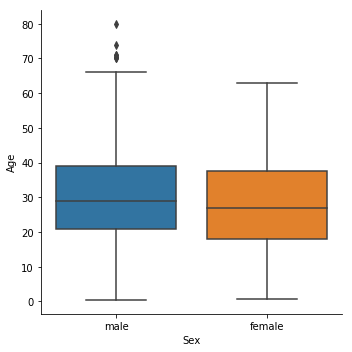

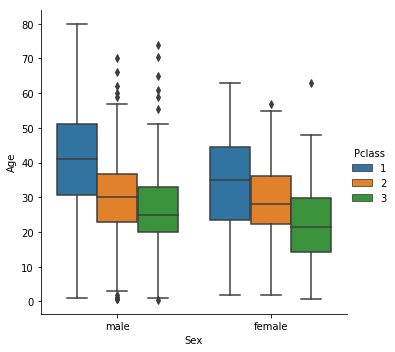

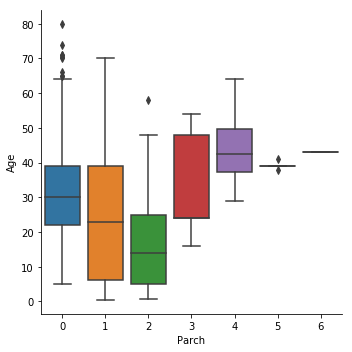

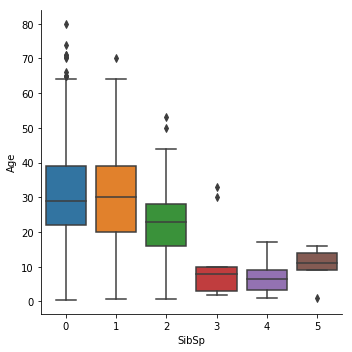

In [55]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=train_df,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=train_df,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=train_df,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=train_df,kind="box")

In [56]:
# convert Sex into categorical value 0 for male and 1 for female
train_df["Sex"] = train_df["Sex"].map({"male": 0, "female":1})
test_df["Sex"] = test_df["Sex"].map({"male": 0, "female":1})

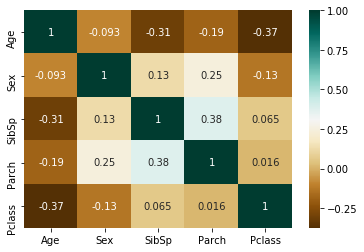

In [57]:
g = sns.heatmap(train_df[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True,)

In [58]:
if 'Cabin' in train_df:
    train_df = train_df.drop(['Cabin'], axis=1)
if 'Cabin' in test_df:
    test_df = test_df.drop(['Cabin'], axis=1)       
    
if 'Ticket' in train_df:
    train_df = train_df.drop(['Ticket'], axis=1)
if 'Ticket' in test_df:
    test_df = test_df.drop(['Ticket'], axis=1)    
    
combine = [train_df, test_df]    

In [59]:
freq_port = train_df.Embarked.dropna().mode()[0]


In [60]:
train_df['FamilySize']  = 0
test_df['FamilySize']  = 0
combine = [train_df, test_df]
for dataset in combine:        
        dataset['FamilySize'] = (dataset['Parch'] + dataset['SibSp']).astype(int) + 1        

In [61]:
train_df['IsAlone'] = 0
test_df['IsAlone'] = 0
train_df.loc[ (train_df.FamilySize == 1), 'IsAlone'] = 1
test_df.loc[ (train_df.FamilySize == 1), 'IsAlone'] = 1

if 'Parch' in test_df:
    test_df = test_df.drop(['Parch'], axis=1)  
if 'SibSp' in test_df:
    test_df = test_df.drop(['SibSp'], axis=1)      

if 'Parch' in train_df:
    train_df = train_df.drop(['Parch'], axis=1)  
if 'SibSp' in train_df:
    train_df = train_df.drop(['SibSp'], axis=1)      

if 'FamilySize' in train_df:
    train_df = train_df.drop(['FamilySize'], axis=1)  
    
if 'FamilySize' in test_df:
    test_df = test_df.drop(['FamilySize'], axis=1)   
    
combine = [train_df, test_df]    

In [62]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [63]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [64]:
emb = pd.get_dummies(train_df['Embarked'],drop_first=True)
emb.head()

,1,2
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0


In [65]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
train_df['Fare'].fillna(train_df['Fare'].dropna().median(), inplace=True)
combine = [train_df, test_df] 

### Age band Feature

In [67]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [68]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [69]:
train_df['AgeBand'] = pd.cut(train_df['Age'], age_buckets,include_lowest=True).astype(str).str.strip('()[]')
age_band_buckets = train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
age_band_buckets = age_band_buckets['AgeBand'].str.split(',', expand=True)
age_band_buckets.rename(columns={ age_band_buckets.columns[0]: "Min" , age_band_buckets.columns[1]: "Max"}, inplace=True)
age_band_buckets = age_band_buckets.dropna()
age_band_buckets.Min = age_band_buckets.Min.astype(float)
age_band_buckets.Max = age_band_buckets.Max.astype(float)
age_band_buckets.sort_values(by='Min', ascending=True,inplace=True)
#age_band_buckets.head(100).sort_values(by='Min', ascending=True)

In [70]:
train_df['AgeInt'] = -1
test_df['AgeInt'] = -1
combine = [train_df, test_df] 
a_rowcount = age_band_buckets.shape[0] -1
a_iterplace = 0
for index, row in age_band_buckets.sort_values(by='Min', ascending=True).iterrows():
    minval =  row['Min']
    maxval = row['Max']
    
    if a_iterplace == a_rowcount:#need to handle max value truncation        
        maxval += 1        
        
    a_iterplace +=1
    for dataset in combine:                         
        dataset.loc[(dataset['Age'] >= minval) & (dataset['Age'] <= maxval), 'AgeInt'] = index        

### Fare band feature

In [71]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], fare_buckets).astype(str).str.strip('()[]')
Fare_band_buckets = train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
Fare_band_buckets = Fare_band_buckets['FareBand'].str.split(',', expand=True)
Fare_band_buckets.rename(columns={ Fare_band_buckets.columns[0]: "Min" , Fare_band_buckets.columns[1]: "Max"}, inplace=True)
Fare_band_buckets = Fare_band_buckets.dropna()
Fare_band_buckets.Min = Fare_band_buckets.Min.astype(float)
Fare_band_buckets.Max = Fare_band_buckets.Max.astype(float)
Fare_band_buckets.sort_values(by='Min', ascending=True,inplace=True)
#Fare_band_buckets.head(100).sort_values(by='Min', ascending=True)

In [72]:
train_df['FareInt'] = -1
test_df['FareInt'] = -1
combine = [train_df, test_df] 
f_rowcount = Fare_band_buckets.shape[0] -1
f_iterplace = 0
for index, row in Fare_band_buckets.sort_values(by='Min', ascending=True).iterrows():
    minval =  row['Min']
    maxval = row['Max']
    
    if f_iterplace == f_rowcount:#need to handle max value truncation        
        maxval += 1        
        
    f_iterplace +=1
    for dataset in combine:                         
        dataset.loc[(dataset['Fare'] >= minval) & (dataset['Fare'] <= maxval), 'FareInt'] = index        

In [73]:
if 'FareBand' in test_df:
    test_df = test_df.drop(['FareBand'], axis=1)  
if 'SibSp' in test_df:
    test_df = test_df.drop(['SibSp'], axis=1)      

if 'FareBand' in train_df:
    train_df = train_df.drop(['FareBand'], axis=1)  
if 'AgeBand' in train_df:
    train_df = train_df.drop(['AgeBand'], axis=1)    
    
if 'Fare' in train_df:
    train_df = train_df.drop(['Fare'], axis=1)  
if 'Age' in train_df:
    train_df = train_df.drop(['Age'], axis=1)   
    
if 'Fare' in test_df:
    test_df = test_df.drop(['Fare'], axis=1)  
if 'Age' in test_df:
    test_df = test_df.drop(['Age'], axis=1)    
    
combine = [train_df, test_df] 

### use name to generate a title

In [74]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df['Title'].value_counts() 

Mr        513
Miss      180
Mrs       126
Master     39
Rare       23
Name: Title, dtype: int64

In [75]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [76]:
if 'Name' in test_df:
    test_df = test_df.drop(['Name'], axis=1)  
if 'Name' in train_df:
    train_df = train_df.drop(['Name'], axis=1)    
    
combine = [train_df, test_df] 

In [77]:
#train_df.info()
print("--"*40)
#test_df.info()

--------------------------------------------------------------------------------


In [78]:
#colormap = plt.cm.RdBu
#plt.figure(figsize=(14,12))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
#sns.heatmap(train_df[["AgeInt", "Pclass","FareInt","Survived","Sex",'IsAlone','Title']].astype(float).corr(),linewidths=0.1,vmax=1.0, 
#            square=True, cmap=colormap, linecolor='white', annot=True)

In [79]:
test_df.head()

,PassengerId,Pclass,Sex,Embarked,IsAlone,AgeInt,FareInt,Title
0,892,3,0,2,0,6,-1,1
1,893,3,1,0,0,10,9,3
2,894,2,0,2,1,14,-1,1
3,895,3,0,0,0,4,-1,1
4,896,3,1,0,1,3,-1,3


## Machine Learning

In [80]:
X_train = train_df.drop("Survived", axis=1)
X_train = X_train.drop("PassengerId", axis=1)
Y_train = train_df["Survived"]

X_test = test_df
X_test = X_test.drop("PassengerId", axis=1)

X_train.shape, Y_train.shape, X_test.shape

((881, 7), (881,), (418, 7))

In [81]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-3,
                     hidden_layer_sizes=(5, 2), random_state=1)

logreg = LogisticRegression()
ridge = RidgeClassifier()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
perceptron = Perceptron(alpha=1e-5)
gaussian = GaussianNB()
linear_svc = LinearSVC()
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=100)

models ={}
models["logreg"] = logreg
models["ridge"] = ridge
models["svc"] = svc
models["knn"] = knn
models["perceptron"] = perceptron
models["mlp"] = mlp
models["gaussian"] = gaussian
models["linear_svc"] = linear_svc
models["sgd"] = sgd
models["decision_tree"] = decision_tree
models["random_forest"] = random_forest

In [82]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import cross_val_score
scores_df = pd.DataFrame()
#allcoeffs = pd.DataFrame(columns=['Feature','Model','Correlation'])
for name, model in models.items():
    model.fit(X_train, Y_train)
    X_Pred = model.predict(X_train)
        
    sc = round(model.score(X_train, Y_train) * 100, 2)    
    precision, recall, fscore, support = score(Y_train, X_Pred)

    #coeff_df = pd.DataFrame(X_train.columns.delete(0))
    #coeff_df['Model'] = name
    #coeff_df.rename(columns={ coeff_df.columns[0]: "Feature" }, inplace=True)
    #coeff_df["Correlation"] = pd.Series(model.coef_[0])    
    
    #allcoeffs = allcoeffs.append(coeff_df)
    
    cvscore = cross_val_score(model, X_train, Y_train,
                                scoring='accuracy', cv=4)
    
    cv_mean = round(cvscore.mean() * 100, 2)   
    cv_stddev = round(cvscore.std() * 100 * 2, 2)   
    scores_df = scores_df.append({
                                    'Model':name, 
                                    'Score':sc,
                                    'CV_Mean': cv_mean,
                                    'CV_SDEV': cv_stddev,
                                    'Precision': precision,
                                    'recall': recall,
                                    'fscore': fscore,
                                    'support': support                                    
                                
    }, ignore_index=True)

/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/mathewlech/anaconda3/envs/primary_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning

In [83]:
scores_df = scores_df[['Model', 'Score', 'CV_Mean','CV_SDEV', 'Precision','recall','fscore','support',]]
scores_df.sort_values(by='Score', ascending=False,inplace=True)
scores_df.head(100)

,Model,Score,CV_Mean,CV_SDEV,Precision,recall,fscore,support
9,decision_tree,92.51,79.68,2.48,"[0.9087779690189329, 0.9566666666666667]","[0.9759704251386322, 0.8441176470588235]","[0.9411764705882353, 0.896875]","[541, 340]"
10,random_forest,92.51,80.82,2.83,"[0.9173989455184535, 0.9391025641025641]","[0.9648798521256932, 0.861764705882353]","[0.9405405405405406, 0.8987730061349694]","[541, 340]"
3,knn,87.74,78.66,2.43,"[0.8957952468007313, 0.8473053892215568]","[0.9057301293900185, 0.8323529411764706]","[0.9007352941176471, 0.8397626112759644]","[541, 340]"
2,svc,85.93,80.25,5.11,"[0.8576329331046312, 0.8624161073825504]","[0.9242144177449169, 0.7558823529411764]","[0.8896797153024911, 0.80564263322884]","[541, 340]"
5,mlp,82.86,80.48,4.60,"[0.8282828282828283, 0.8292682926829268]","[0.9094269870609981, 0.7]","[0.8669603524229075, 0.7591706539074959]","[541, 340]"
1,ridge,80.02,79.91,2.44,"[0.8288288288288288, 0.7515337423312883]","[0.8502772643253235, 0.7205882352941176]","[0.8394160583941606, 0.7357357357357357]","[541, 340]"
4,perceptron,80.02,71.63,8.28,"[0.8436911487758946, 0.7342857142857143]","[0.8280961182994455, 0.7558823529411764]","[0.835820895522388, 0.744927536231884]","[541, 340]"
7,linear_svc,79.80,79.79,2.93,"[0.8246869409660107, 0.7515527950310559]","[0.8521256931608133, 0.711764705882353]","[0.8381818181818183, 0.7311178247734138]","[541, 340]"
0,logreg,79.68,79.00,2.91,"[0.8278985507246377, 0.7446808510638298]","[0.844731977818854, 0.7205882352941176]","[0.8362305580969808, 0.7324364723467863]","[541, 340]"
6,gaussian,77.07,76.17,7.56,"[0.8480492813141683, 0.6751269035532995]","[0.7634011090573013, 0.7823529411764706]","[0.8035019455252917, 0.7247956403269755]","[541, 340]"


In [84]:
scores_df.sort_values(by='CV_Mean', ascending=False,inplace=True)
scores_df.head(100)

,Model,Score,CV_Mean,CV_SDEV,Precision,recall,fscore,support
10,random_forest,92.51,80.82,2.83,"[0.9173989455184535, 0.9391025641025641]","[0.9648798521256932, 0.861764705882353]","[0.9405405405405406, 0.8987730061349694]","[541, 340]"
5,mlp,82.86,80.48,4.60,"[0.8282828282828283, 0.8292682926829268]","[0.9094269870609981, 0.7]","[0.8669603524229075, 0.7591706539074959]","[541, 340]"
2,svc,85.93,80.25,5.11,"[0.8576329331046312, 0.8624161073825504]","[0.9242144177449169, 0.7558823529411764]","[0.8896797153024911, 0.80564263322884]","[541, 340]"
1,ridge,80.02,79.91,2.44,"[0.8288288288288288, 0.7515337423312883]","[0.8502772643253235, 0.7205882352941176]","[0.8394160583941606, 0.7357357357357357]","[541, 340]"
7,linear_svc,79.80,79.79,2.93,"[0.8246869409660107, 0.7515527950310559]","[0.8521256931608133, 0.711764705882353]","[0.8381818181818183, 0.7311178247734138]","[541, 340]"
9,decision_tree,92.51,79.68,2.48,"[0.9087779690189329, 0.9566666666666667]","[0.9759704251386322, 0.8441176470588235]","[0.9411764705882353, 0.896875]","[541, 340]"
0,logreg,79.68,79.00,2.91,"[0.8278985507246377, 0.7446808510638298]","[0.844731977818854, 0.7205882352941176]","[0.8362305580969808, 0.7324364723467863]","[541, 340]"
3,knn,87.74,78.66,2.43,"[0.8957952468007313, 0.8473053892215568]","[0.9057301293900185, 0.8323529411764706]","[0.9007352941176471, 0.8397626112759644]","[541, 340]"
6,gaussian,77.07,76.17,7.56,"[0.8480492813141683, 0.6751269035532995]","[0.7634011090573013, 0.7823529411764706]","[0.8035019455252917, 0.7247956403269755]","[541, 340]"
8,sgd,58.23,72.77,17.68,"[0.8878923766816144, 0.4787234042553192]","[0.3659889094269871, 0.9264705882352942]","[0.5183246073298429, 0.6312625250501002]","[541, 340]"


In [85]:
# Random Forest is the best algo to use for prediction
Y_pred = random_forest.predict(X_test)
X_test = test_df

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })


In [86]:
#create submission file
#submission.to_csv('/home/mathewlech/sandbox_local/output/titanic/submission.csv', index=False)
#submission.head(500)